In [1]:
import pprint
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# VARIABLES CONFIGURATION
experiment_id = "19-07-1000"

In [13]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

uri = "localhost:27017"
client = MongoClient(uri, server_api=ServerApi('1'))

client.admin.command('ping')

{'ok': 1.0}

In [30]:
db = client.test
historical_evolution_data = db.historicalEvolutionData
problem_instances = db.probleminstances

def convert_cost_values_to_percentages(costs):
    percentage_values = []
    start_value = costs[0]
    if start_value == 0:
        return [100 for _ in range(0, len(costs))]

    for i in range(0, len(costs)):
        percentage_values.append(costs[i] / start_value * 100)
    return percentage_values

def convert_to_percentages(array):
    for i in range(0, len(array)):
        array[i] = convert_cost_values_to_percentages(array[i])

def get_percentages_by_solver(solver_name):
    data = historical_evolution_data.find({"experimentId" : experiment_id, "solverName" : solver_name})
    cost_data = list(map(lambda x: x["costData"], data))
    convert_to_percentages(cost_data)
    percentages = np.array(cost_data, dtype=object)
    return np.mean(percentages, axis=0)

def get_percentages_by_solver_with_congestion_boundary(solver_name, avg_congestion_bound):
    instances = problem_instances.find({"experimentId" : experiment_id, "featureDescription.avgCongestion" : {"$lte" : avg_congestion_bound}})
    instance_ids = list(map(lambda x: x["instanceId"], instances))
    data = historical_evolution_data.find({"experimentId" : experiment_id, "solverName" : solver_name, "instanceId" : {"$in" : instance_ids}})
    cost_data = list(map(lambda x: x["costData"], data))
    convert_to_percentages(cost_data)
    percentages = np.array(cost_data, dtype=object)
    return np.mean(percentages, axis=0)


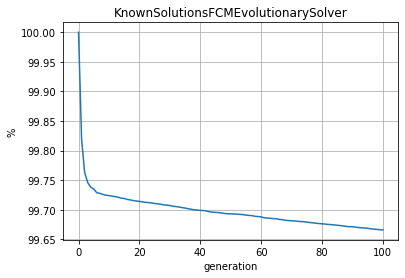

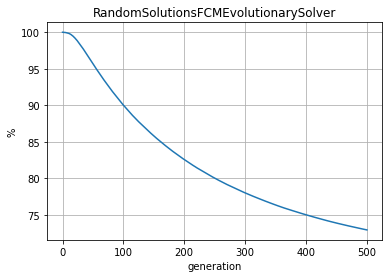

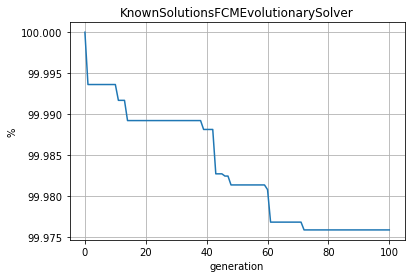

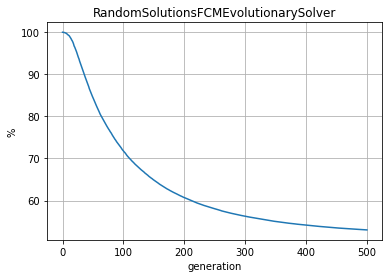

In [41]:
def create_percentage_plot(solver_name):
    fig, ax = plt.subplots()
    average_percentages = get_percentages_by_solver(solver_name)
    ax.plot(average_percentages)

    ax.set(xlabel='generation', ylabel='%',
       title= solver_name)
    ax.grid()

    plt.show()

def create_percentage_with_avg_congestion_boundary_plot(solver_name, avg_congestion_bound):
    fig, ax = plt.subplots()
    average_percentages = get_percentages_by_solver_with_congestion_boundary(solver_name, avg_congestion_bound)
    ax.plot(average_percentages)

    ax.set(xlabel='generation', ylabel='%',
       title= solver_name)
    ax.grid()

    plt.show()


create_percentage_plot("KnownSolutionsFCMEvolutionarySolver")
create_percentage_plot("RandomSolutionsFCMEvolutionarySolver")

create_percentage_with_avg_congestion_boundary_plot("KnownSolutionsFCMEvolutionarySolver", 0.2)
create_percentage_with_avg_congestion_boundary_plot("RandomSolutionsFCMEvolutionarySolver", 0.2)

In [20]:
def create_no_improvement_threshold_plot(solver_name):
    data = historical_evolution_data.find({"experimentId" : experiment_id, "solverName" : solver_name})
    box_width = 25
    generation_lengths = list(map(lambda x: len(x["costData"]) % box_width, data))
    generation_lengths = list(sorted(set(generation_lengths)))
    print(generation_lengths)

    fig, ax = plt.subplots()
    ax.bar([1,2,3,4,5], [1,2,3,4,5])

    ax.set_ylabel('fruit supply')
    ax.set_title('Fruit supply by kind and color')
    ax.legend(title='Fruit color')

    plt.show()


#create_no_improvement_threshold_plot("KnownSolutionsFCAPSMNITEvolutionarySolver")

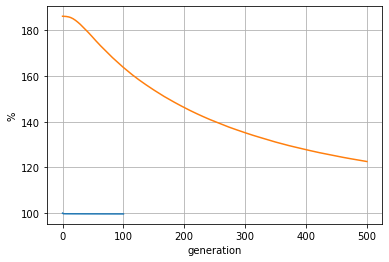

In [21]:
def cost_values_to_percentages(costs, start_value):
    percentage_values = []
    for i in range(0, len(costs)):
        percentage_values.append(costs[i] / start_value * 100)
    return percentage_values

def get_historical_evolution_data(solvers):
    solvers_and_costs = []
    for solver_name in solvers:
        solver_data= historical_evolution_data.find({"experimentId" : experiment_id, "solverName" : solver_name})
        costs = list(map(lambda x: x["costData"], sorted(solver_data, key= lambda x: x["instanceId"])))
        filtered_costs = list(filter(lambda x: x[0] > 0, costs))
        solvers_and_costs.append((solver_name, filtered_costs))
    return solvers_and_costs

def convert_costs_to_percentages(solvers_and_costs, instance):
    costs = []
    for j in range(0, len(solvers_and_costs)):
        costs.append(solvers_and_costs[j][1][instance])
    base_value = min(costs)[0]
    for i in range(0, len(costs)):
        solvers_and_costs[i][1][instance] = cost_values_to_percentages(costs[i], base_value)

def mean_percentages(solvers_and_costs):
    solvers_and_percentages = []
    for i in range(0, len(solvers_and_costs)):
        meaned_percentages = np.mean(solvers_and_costs[i][1],axis=0)
        solvers_and_percentages.append((solvers_and_costs[i][0], meaned_percentages))
    return solvers_and_percentages

def draw_plot(solvers_and_percentages):
    fig, ax = plt.subplots()

    for i in range(0, len(solvers_and_percentages)):
        ax.plot(solvers_and_percentages[i][1])

    ax.set(xlabel='generation', ylabel='%',
       title= "")
    ax.grid()

    plt.show()

def create_comparisons_chart(solvers):
    solvers_and_costs = get_historical_evolution_data(solvers)
    instance_count = len(solvers_and_costs[0][1])
    for i in range(0, instance_count):
        convert_costs_to_percentages(solvers_and_costs, i)
    solvers_and_percentages = mean_percentages(solvers_and_costs)
    draw_plot(solvers_and_percentages)

solver_names = ["KnownSolutionsFCMEvolutionarySolver", "RandomSolutionsFCMEvolutionarySolver"]
create_comparisons_chart(solver_names)